# Titanic - Machine Learning from Disaster

https://www.kaggle.com/competitions/titanic

https://www.kaggle.com/competitions/titanic/data

Sources of inspiration:
- https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/notebook?scriptVersionId=27280410
- https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb

In [65]:
import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    precision_recall_curve,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)

## Download dataset

In [3]:
import kagglehub
path = kagglehub.competition_download("titanic")
path

'/home/martin/.cache/kagglehub/competitions/titanic'

In [4]:
train_data = pd.read_csv(os.path.join(path, "train.csv"))
train_data.shape

(891, 12)

In [5]:
test_data = pd.read_csv(os.path.join(path, "test.csv"))
test_data.shape

(418, 11)

## Explore data

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

# The goal of the competition is to predict Survival based on test_data.
# We wouldn't have that kind of luxury in real world and we would stay away from test_data as far as we can (so that we can prepare for production data).
# Here however, we should include the test_data, in exploration, augmentation and feature creation (so that we are best prepared for the test data).
all_data = concat_df(train_data, test_data)

### Survival rate based on Sex

In [9]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [10]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


## Prepare the Data for Machine Learning Algorithms

### Feature Engineering

### Missing values

In [11]:
all_data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

#### Age

#### Cabin

**New Deck Feature**

Cabin alone doesn't give us a lot of information, but we can extract Deck from that feature which better correlates with other features.

**Missing Cabin values**

As noted in [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410&cellId=22),
people with missing Cabin value have low survival rate, so it can be a good feature and let's do the same and create special category for them (instead of replacing it with most common).

In [12]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
all_data["Deck"] = all_data["Cabin"].apply(lambda s: s[0] if pd.notnull(s) else 'M')

**Deck T**

As noted in [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410&cellId=22),
"There is one person on the boat deck in T cabin and he is a 1st class passenger. T cabin passenger has the closest resemblance to A deck passengers so he is grouped with A deck".

In [13]:
# Passenger in the T deck is changed to A
idx = all_data[all_data["Deck"] == 'T'].index
all_data.loc[idx, "Deck"] = 'A'

In [14]:
all_data_copy = all_data.copy()

all_data_copy["Deck_Num"] = LabelEncoder().fit_transform(all_data_copy["Deck"])
all_data_copy["Cabin_Num"] = LabelEncoder().fit_transform(all_data_copy["Cabin"])

corr_matrix = all_data_copy.corr(numeric_only=True)
corr_matrix["Survived"].sort_values(ascending=False)


Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Cabin_Num     -0.253406
Deck_Num      -0.290485
Pclass        -0.338481
Name: Survived, dtype: float64

#### Embarked

Just replace NaN with most common value.

In [15]:
all_data["Embarked"] = all_data["Embarked"].fillna(all_data["Embarked"].mode().iloc[0])

In [16]:
all_data.isnull().sum()

Age             263
Cabin          1014
Embarked          0
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Deck              0
dtype: int64

#### Fare

In [17]:
# Filling the missing values in Fare with the medians of related groups
all_data["Fare"] = all_data.groupby(['Pclass', 'Parch', 'SibSp'])["Fare"].transform(lambda x: x.fillna(x.median()))

In [18]:
all_data.isnull().sum()

Age             263
Cabin          1014
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Deck              0
dtype: int64

As mentioned in [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410&cellId=47),
13 should give use enough information (as proven by having similar correlation with "Survived" as logarithmic Fare).

In [19]:
all_data["Fare_Grouped"] = pd.qcut(all_data['Fare'], 13)
all_data["Fare_Grouped"] = LabelEncoder().fit_transform(all_data["Fare_Grouped"])

In [20]:
# TODO: compare if it is better to use "Fare_Log" or "Fare_Grouped" (intuitively I would say that Random Forest should be allowed to slice continuous values itself)
# Fare is skewed slightly to the left so log function will fix it to resemble bell curve (ML models work with that better).
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
all_data["Fare_Log"] = log_transformer.transform(all_data[["Fare"]])

/home/martin/miniconda/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [21]:
corr_matrix = all_data.corr(numeric_only=True)
corr_matrix["Survived"].sort_values(ascending=False)

Survived        1.000000
Fare_Log        0.325452
Fare_Grouped    0.321206
Fare            0.257307
Parch           0.081629
PassengerId    -0.005007
SibSp          -0.035322
Age            -0.077221
Pclass         -0.338481
Name: Survived, dtype: float64

## Train model

In [22]:
train_data, test_data = divide_df(all_data)

In [23]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch", "Deck", "Embarked", "Fare_Grouped"]
X = pd.get_dummies(train_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)


RandomForestClassifier(max_depth=5, random_state=1)

In [24]:
feature_importances = model.feature_importances_

sorted(zip(feature_importances,
           X.columns),
           reverse=True)

[(0.30860223438673834, 'Sex_male'),
 (0.2561944641166527, 'Sex_female'),
 (0.11891323841742663, 'Pclass'),
 (0.09279066117841518, 'Fare_Grouped'),
 (0.07601665002098043, 'Deck_M'),
 (0.039275625789605306, 'Parch'),
 (0.03808875322398648, 'SibSp'),
 (0.014865889029296428, 'Embarked_C'),
 (0.011454059254829476, 'Embarked_S'),
 (0.01094188337371164, 'Deck_E'),
 (0.008679173698915299, 'Deck_B'),
 (0.0068893062274435635, 'Deck_D'),
 (0.006613109881636018, 'Embarked_Q'),
 (0.004125787982528375, 'Deck_C'),
 (0.0026580688893450186, 'Deck_F'),
 (0.00207253609142706, 'Deck_A'),
 (0.0018185584370621418, 'Deck_G')]

## Evaluate model (accuracy, RoC, etc.)

### Accuracy

In [25]:
cross_val_score(model, X, y, cv=3, scoring="accuracy")

array([0.78787879, 0.82154882, 0.8013468 ])

### Confusion Matrix

In [32]:
y_train_pred = cross_val_predict(model, X, y, cv=3)

cm = confusion_matrix(y, y_train_pred)
cm

array([[493,  56],
       [119, 223]])

### Precision and Recall

In [34]:
# TP / (FP + TP)
# cm[1, 1] / (cm[0, 1] + cm[1, 1])
precision_score(y, y_train_pred)

0.7992831541218638

In [35]:
# TP / (FN + TP)
# cm[1, 1] / (cm[1, 0] + cm[1, 1])
recall_score(y, y_train_pred)

0.652046783625731

In [37]:
# cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)
f1_score(y, y_train_pred)

0.7181964573268921

### Precision Recall Curve

In [59]:
y_pred_proba = cross_val_predict(model, X, y, cv=3, method="predict_proba")
y_pred_proba[:2]

array([[0.90155321, 0.09844679],
       [0.02066352, 0.97933648]])

In [66]:
y_scores = y_pred_proba[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

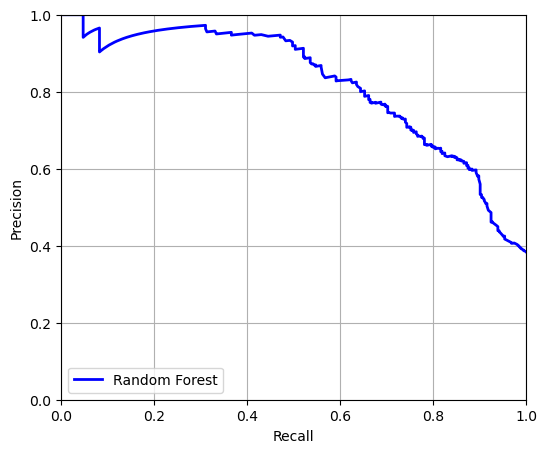

In [67]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, "b-", linewidth=2,
         label="Random Forest")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

### ROC Curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y, y_scores)

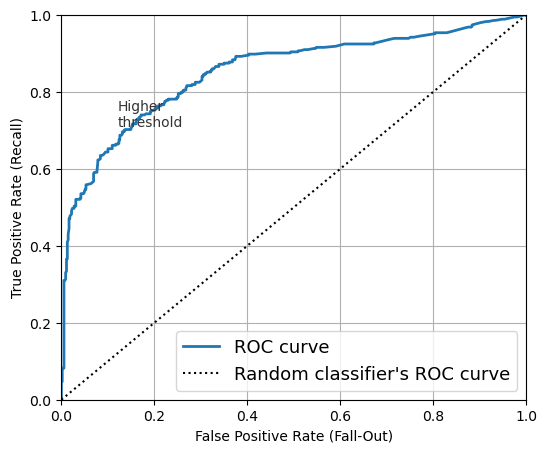

In [61]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

In [62]:
print(roc_auc_score(y, y_scores))

0.8514524014955422


## Upload new submission

In [104]:
X_test = pd.get_dummies(test_data[features])
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions.astype('int64')})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


| WARNING: Don't forget to change "changeId" so that we can track version of jupyter book this submission is from! |
| --- |

In [105]:
# In case we run this cell by accident, this script disables its execution - comment out to enable it again
%%script false --no-raise-error

from kaggle.api.kaggle_api_extended import KaggleApi

changeId = "26e04ec52b9e234d63d0ce68762314053be6dbd9"

api = KaggleApi()
api.authenticate()

# kaggle competitions submit -c titanic -f submission.csv -m "Message"
api.competition_submit(file_name="submission.csv", message=f"ChangeId: {changeId}", competition="titanic")

100%|██████████| 2.77k/2.77k [00:00<00:00, 6.16kB/s]


Successfully submitted to Titanic - Machine Learning from Disaster